<a href="https://colab.research.google.com/github/CalculatedContent/WeightWatcher-Examples/blob/main/WW_MLP3_LearningRates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows that
# Alpha decreases with increasing Test Accuracy

## But if alpha < 2, the model may be overtrained

### This is the simplest possible modern MLP, 3 layers trained on MNIST

- Using Keras, following this sample code:
    - https://www.kaggle.com/sathianpong/3-ways-to-implement-mlp-with-keras

- trained  with a early stopping on the training loss,
    - upto 1000 epochs (but usually < 100)
    - delta_min = 0.001
- all layers are frozen, except for layer 1 (which is 300 x 100)
- the learning rate is varied to induce the effect at very large learning rates (which correspond to small batch sizes)


Note: To apply the theory in this way, it is necessary to:
- to train the all models  for as long / to as high of accuracy as possible
- with the exact same initial conditions

We don't necessarily need to freeze the other layers, but this is done for clarity here.  







## Keras Sequential API

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import Image, clear_output

sns.set()
tf.__version__

'2.15.0'

In [2]:
# https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

# https://tensorflow.google.cn/api_docs/python/tf/config/experimental/enable_op_determinism

%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import random
def reset_random_seeds(seed_value=1):
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   tf.keras.utils.set_random_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)
   tf.config.experimental.enable_op_determinism()

reset_random_seeds()

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [3]:
!pip install weightwatcher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.6 MB/s eta 0:00:00


### Download the Fashion MNIST dataset

In [4]:
data = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = data.load_data()
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

clear_output()
print("X_train shape :",X_train.shape)
print("X_test shape :", X_test.shape)

X_train shape : (60000, 28, 28)
X_test shape : (10000, 28, 28)


### Recale the data

In [5]:
X_train = X_train/255.0
X_test = X_test/255.0

### Build the simplest MLP, need 3 layers

- input layer
- hidden layer
- output layer

Initialize all models with the same weight matrices

In [6]:
def build_model(lr=0.01):

  reset_random_seeds()

  initializer = tf.keras.initializers.GlorotNormal(seed=1)

  # Specify the loss fuction, optimizer, metrics
  model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape = [28,28]),
      tf.keras.layers.Dense(300, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Dense(100, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=initializer),
  ])


  model.compile(
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  model.layers[0].trainable = True
  model.layers[1].trainable = True
  model.layers[2].trainable = True
  model.layers[3].trainable = True

  return model



In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:


model = build_model()

history = model.fit(
  X_train, y_train, epochs=1, batch_size=16, verbose=2
)

3750/3750 - 10s - loss: 0.4461 - sparse_categorical_accuracy: 0.8799 - 10s/epoch - 3ms/step


### Should be:

3750/3750 - 9s - loss: 0.6044 - sparse_categorical_accuracy: 0.7953 - 9s/epoch - 2ms/step






In [9]:
model = build_model()

history = model.fit(
  X_train, y_train, epochs=1, batch_size=16, verbose=2
)

3750/3750 - 8s - loss: 0.4461 - sparse_categorical_accuracy: 0.8799 - 8s/epoch - 2ms/step


In [10]:
# Train the model
def train_model(lr):

    model = build_model(lr=lr)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=2, min_delta=0.0001, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=1000, batch_size=32,
        validation_split=0.1,
        verbose=2, callbacks=[early_stopping_callback]
    )
    return model, history

In [11]:

model, H = train_model(lr=0.1)

Epoch 1/1000
1688/1688 - 6s - loss: 0.2728 - sparse_categorical_accuracy: 0.9179 - val_loss: 0.1674 - val_sparse_categorical_accuracy: 0.9473 - 6s/epoch - 3ms/step
Epoch 2/1000
1688/1688 - 5s - loss: 0.1124 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.0929 - val_sparse_categorical_accuracy: 0.9735 - 5s/epoch - 3ms/step
Epoch 3/1000
1688/1688 - 5s - loss: 0.0763 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.0780 - val_sparse_categorical_accuracy: 0.9780 - 5s/epoch - 3ms/step
Epoch 4/1000
1688/1688 - 5s - loss: 0.0559 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.0826 - val_sparse_categorical_accuracy: 0.9753 - 5s/epoch - 3ms/step
Epoch 5/1000
1688/1688 - 5s - loss: 0.0422 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.0681 - val_sparse_categorical_accuracy: 0.9812 - 5s/epoch - 3ms/step
Epoch 6/1000
1688/1688 - 5s - loss: 0.0297 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.0949 - val_sparse_categorical_accuracy: 0.9733 - 5s/epoch - 3ms/step
Epoch 7/1000
168

In [12]:
H.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

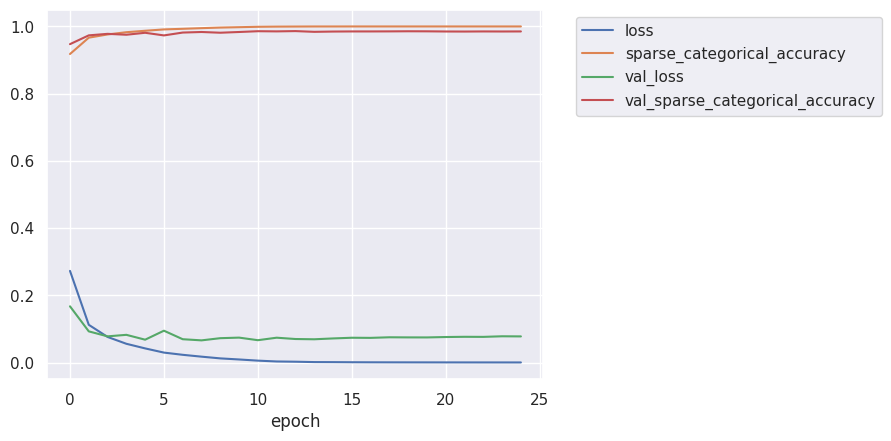

In [13]:
pd.DataFrame(H.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [14]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
watcher.describe()

,layer_id,name,M,N,Q,layer_type,longname,num_evals,rf
0,1,dense_9,300,784,2.613333,dense,None,300,1
1,2,dense_10,100,300,3.000000,dense,None,100,1
2,3,dense_11,10,100,10.000000,dense,None,10,1


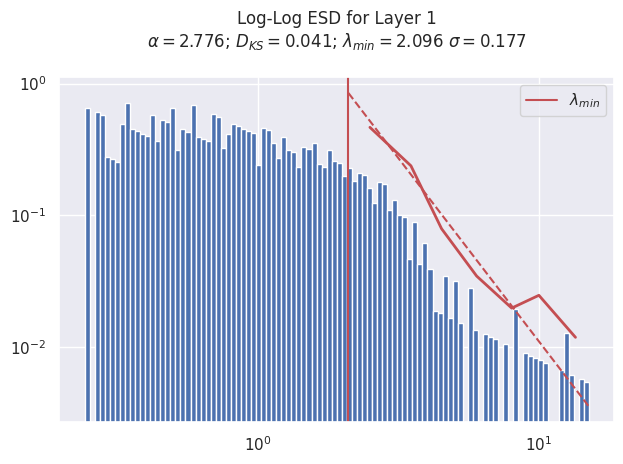

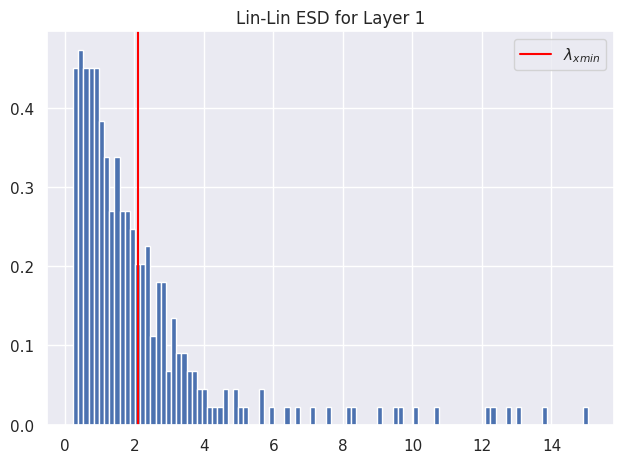

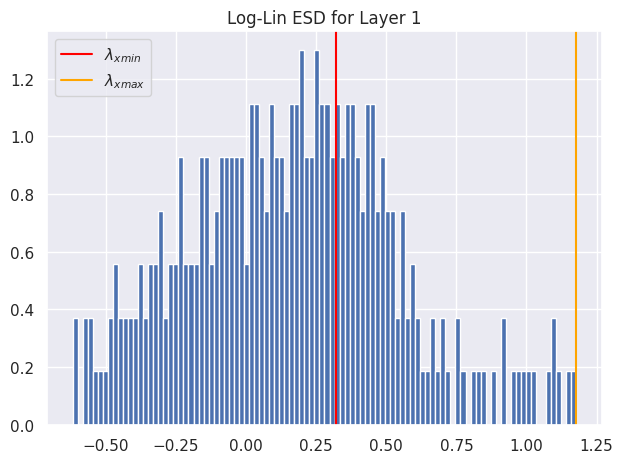

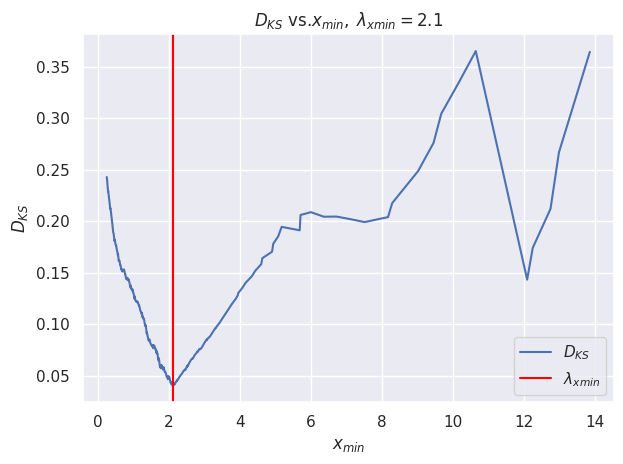

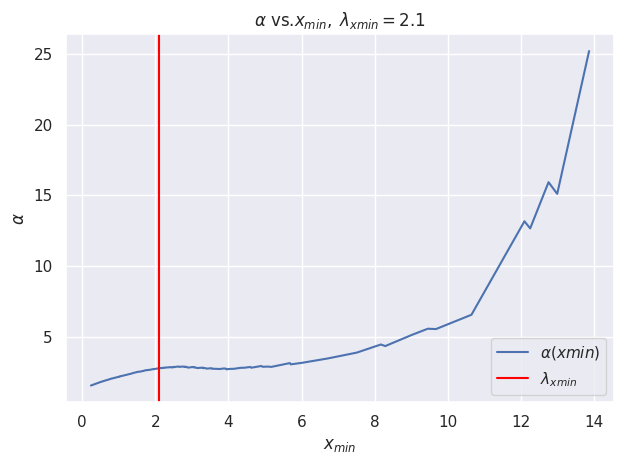

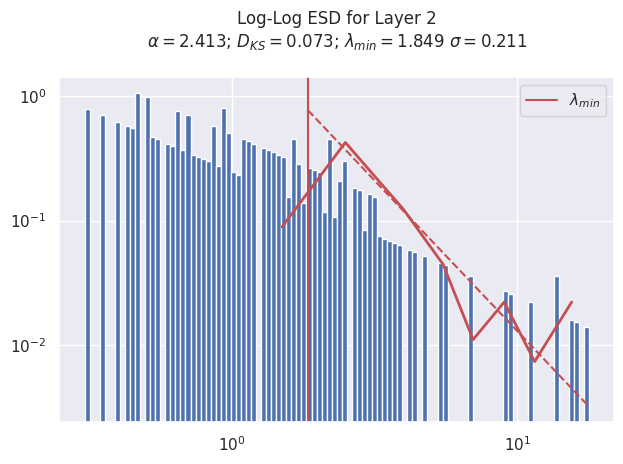

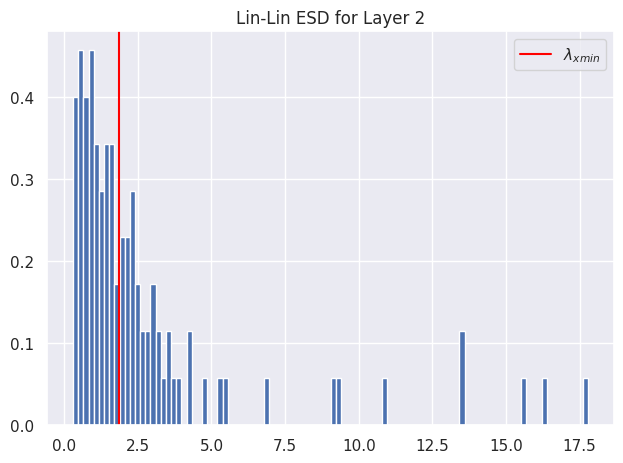

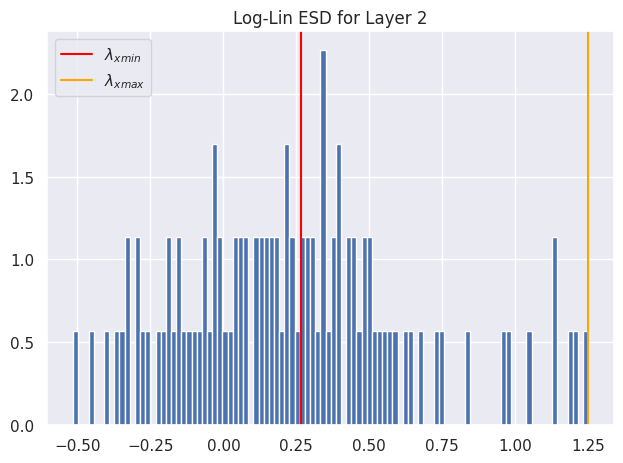

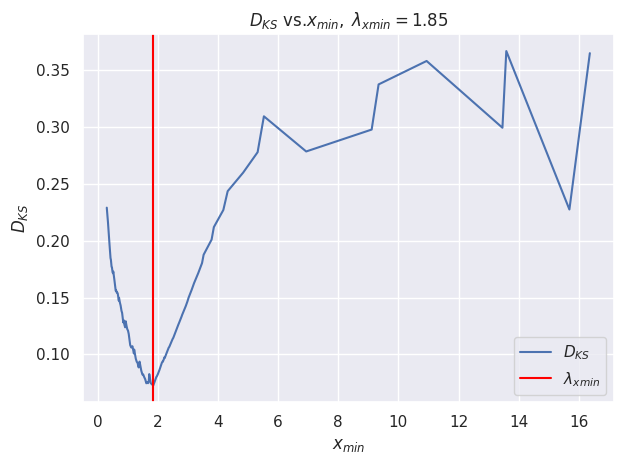

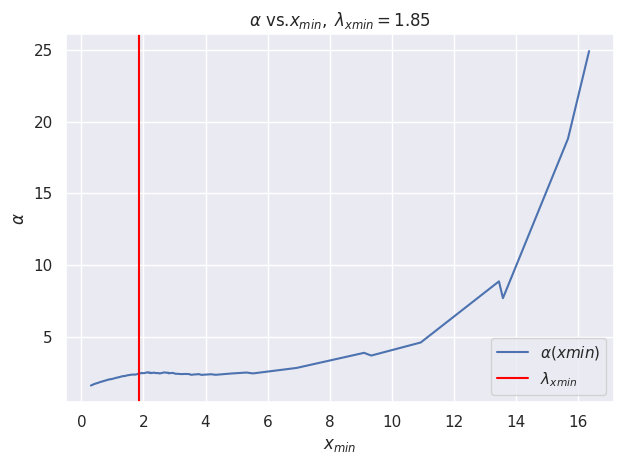

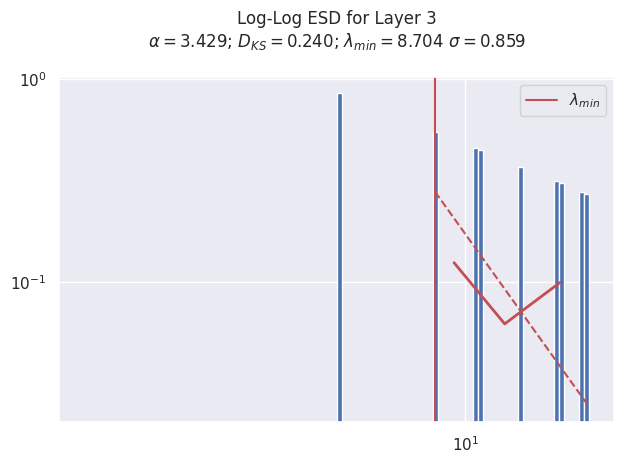

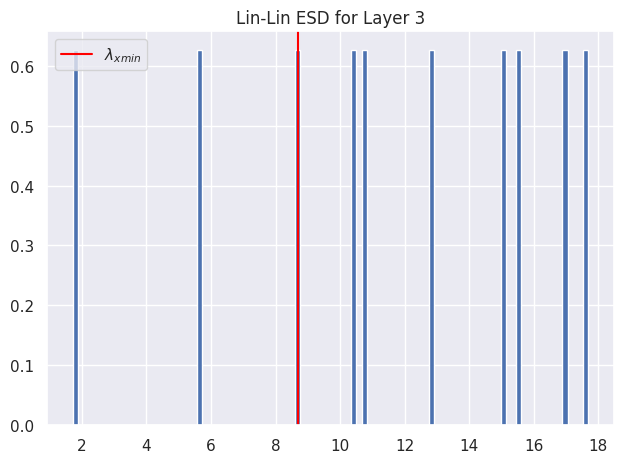

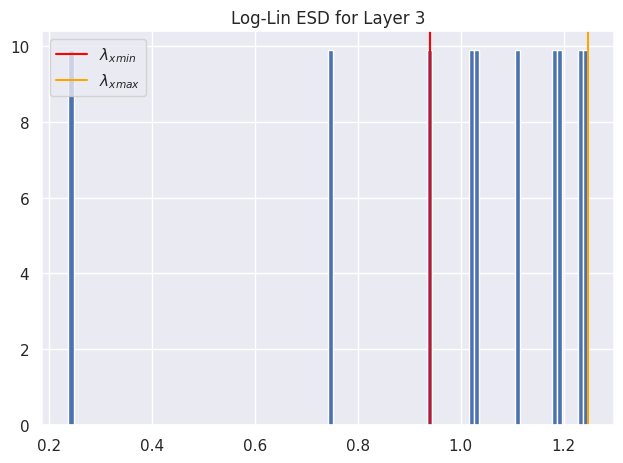

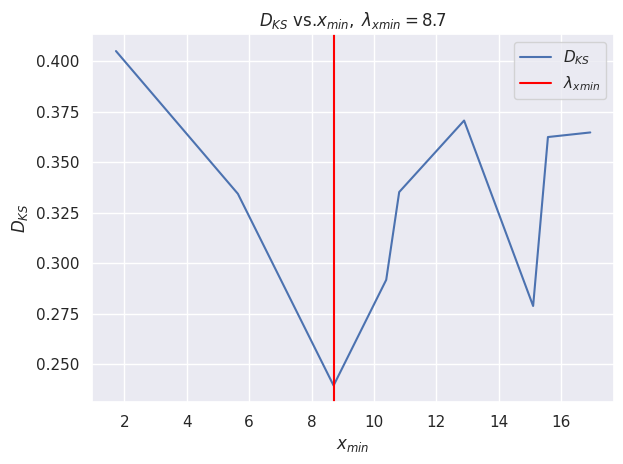

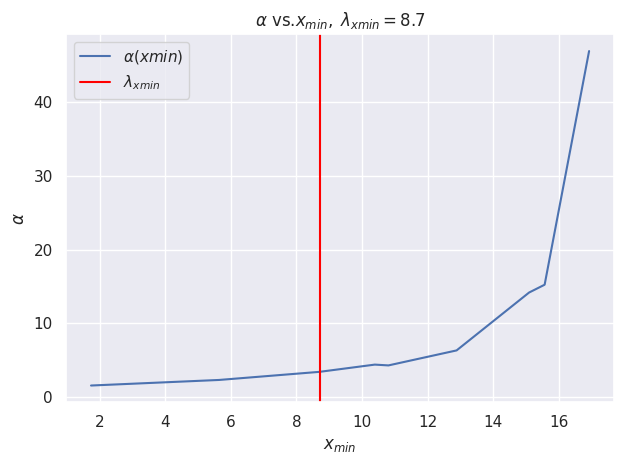

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,sigma,spectral_norm,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,xmax,xmin
0,1,dense_9,0.040568,300,784,2.613333,2.776140,3.269601,0.945173,True,...,0.176733,15.057429,42.690697,success,3.880390,0.490659,,0,15.057429,2.096021
1,2,dense_10,0.072741,100,300,3.000000,2.413021,3.016961,0.894722,True,...,0.210641,17.794416,15.376739,success,4.218343,0.552653,,0,17.794416,1.849412
2,3,dense_11,0.239564,10,100,10.000000,3.429268,4.278446,0.953082,True,...,0.858876,17.685871,6.527697,success,4.205457,1.314948,,0,17.685871,8.704075


<Figure size 640x480 with 0 Axes>

In [15]:
watcher.analyze(plot=True)

### We can now vary the hyperparameters and see how the test accuracy changes
 > defaults: https://keras.io/api/optimizers/sgd/'

The goal is to get some significant variation in the test (validation) accuraies, and see how our weightwatcher metrics compare

In [ ]:
# Changes just the learning rate
all_reaults = []
all_lr = [0.001, 0.025, 0.005, 0.075, 0.01, 0.025, 0.05, 0.075, 0.1]


mlp3_results = None
models = {}
histories = {}
for lr in all_lr:
    layer_ids = [1]
    modelname = 'MLP3'
    print(f"Analyzing {modelname} lr={lr}")
    model, H = train_model(lr)
    watcher = ww.WeightWatcher(model=model)
    results = watcher.analyze(layers=layer_ids)

    val_acc = H.history['val_sparse_categorical_accuracy'][-1]

    histories[lr] = H
    models[lr]= model

    results['modelname'] = modelname
    results['learning_rate'] = lr
    results['H_val_acc'] = H.history['val_sparse_categorical_accuracy'][-1]


    score = model.evaluate(X_train, y_train, verbose = 0)
    results['train_accuracy'] = score[1]
    score = model.evaluate(X_test, y_test, verbose = 0)
    results['test_accuracy'] = score[1]


    pd.DataFrame(H.history).plot()
    plt.xlabel("epoch")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.title(f"learning_rate {lr}")
    plt.show()

    #filename = f"/content/drive/My Drive/MLP3/model_lr{lr}"
    #model.save(filename)

    if mlp3_results is None:
        mlp3_results = results
    else:
        mlp3_results = pd.concat((mlp3_results, results))

#filename = f"/content/drive/My Drive/MLP3/mlp3_results.feather"
#mlp3_results.to_feather(filename)

Analyzing MLP3 lr=0.001
Epoch 1/1000
1688/1688 - 6s - loss: 1.8025 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.2566 - val_sparse_categorical_accuracy: 0.7765 - 6s/epoch - 3ms/step
Epoch 2/1000
1688/1688 - 5s - loss: 0.9775 - sparse_categorical_accuracy: 0.7984 - val_loss: 0.6848 - val_sparse_categorical_accuracy: 0.8697 - 5s/epoch - 3ms/step
Epoch 3/1000
1688/1688 - 5s - loss: 0.6448 - sparse_categorical_accuracy: 0.8502 - val_loss: 0.4910 - val_sparse_categorical_accuracy: 0.8867 - 5s/epoch - 3ms/step
Epoch 4/1000
1688/1688 - 5s - loss: 0.5153 - sparse_categorical_accuracy: 0.8708 - val_loss: 0.4046 - val_sparse_categorical_accuracy: 0.8993 - 5s/epoch - 3ms/step
Epoch 5/1000
1688/1688 - 5s - loss: 0.4489 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.3568 - val_sparse_categorical_accuracy: 0.9075 - 5s/epoch - 3ms/step
Epoch 6/1000
1688/1688 - 5s - loss: 0.4082 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.3270 - val_sparse_categorical_accuracy: 0.9120 - 5s/epoch - 3

In [ ]:
mlp3_results.plot.scatter(x='learning_rate',y='test_accuracy')
plt.title(r"Learning Rate  vs Test Accuracy")
plt.xlabel(r"Learning Rate")
plt.ylabel("Test Accuracy")

In [ ]:
mlp3_results.plot.scatter(x='alpha',y='train_accuracy')
mlp3_results.plot.scatter(x='alpha',y='test_accuracy')

In [ ]:
mlp3_results.plot.scatter(x='alpha',y='test_accuracy')
plt.title(r"WeightWatcher PL Alpha ($\alpha$) metric vs Test Accuracy")
plt.xlabel(r"Alpha ($\alpha$) metric")
plt.ylabel("Test Accuracy")